In [1]:
import imp
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import matplotlib.transforms as trans
from mpl_toolkits import mplot3d

from scipy.optimize import minimize

Import the specific Mobius "Sediment oxygen" model:

In [2]:
wrapper_fpath = (r'../../PythonWrapper/mobius.py')
mobius = imp.load_source('mobius', wrapper_fpath)

calib_fpath = (r'../../PythonWrapper/mobius_calib_uncert_lmfit.py')
calib = imp.load_source('calib', calib_fpath)

mobius.initialize(r'./sedimentoxygen.so')   #Linux: use r'./sedimentoxygen.so'

Set up a "data set" object containing parameters and results of this session

In [3]:
dataset = mobius.DataSet.setup_from_parameter_and_input_files('testparameters.dat', 'testinputs.dat')

water_sed_idx = dataset.get_parameter_uint('Upper layer of production zone', [])
z_resolution  = dataset.get_parameter_double('Z resolution', [])


nlevels = 102
ntime  = 44     #How many of the last time steps of the model run do we want to look at when doing processing? (also affects the 3d plot)

max_display_depth = 0.9   #how many cm. to display in the plots. Also the depth used to compute percentages. This should not be set higher than 5.


#The one to ‘oxic’ conditions at 65 um O2 l-1 (but this one will likely be higher than our highest estimates at 25% PAL).
#The one at ‘hypoxic’ conditions at 22 umol O2 l-1 (this one will likely be quite shallow in the sediment).
#The ‘zero’ at ne at <0.01 um O2 L-1. This one will be the most important.
oxic     = 65.0e-3   #Note: units in our data block are in umol/cm3, so have to convert from umol/l
hypoxic  = 22.0e-3
zeroconc = 2e-3

Set up a function that runs the model with a specific temperature and returns the result data. It also returns the time index (relative to the data block) of the time when the sediment-oxygen interface is at its max and min values

In [4]:
#def run_scenario(temperature=15.0, ppO2=21, porosity=0.6, maxprod=1.7e-5, maxutil=None, prodQ10=None, resp=1.5e-6, respQ10=None, day_length=21) :
def run_scenario(temperature=15.0, ppO2=21, porosity=0.6, maxprod=1.7e-5, maxutil=None, prodQ10=None, resp=9e-6, respQ10=None, day_length=21, salinity=35) :
    
    dataset_copy = dataset.copy()
    
    dataset_copy.set_parameter_double('Temperature', [], temperature)
    dataset_copy.set_parameter_double('Salinity', [], salinity)
    dataset_copy.set_parameter_double('Atmospheric O2 partial pressure', [], ppO2)
    dataset_copy.set_parameter_double('Sediment porosity', [], porosity)
    
    if not maxprod is None :
        dataset_copy.set_parameter_double('Maximum O2 production at 20°C', [], maxprod)
    if not maxutil is None :
        dataset_copy.set_parameter_double('Maximum light utilization', [], maxutil)
    if not prodQ10 is None :
        dataset_copy.set_parameter_double('Production rate response to a 10° change in temperature (Q10)', [], prodQ10)
    if not resp is None :
        dataset_copy.set_parameter_double('Respiration rate at 20°C', [], resp)
    if not respQ10 is None :
        dataset_copy.set_parameter_double('Respiration rate response to a 10° change in temperature (Q10)', [], respQ10)
    if not day_length is None :
        dataset_copy.set_parameter_double('Day length', [], day_length)
    
    dataset_copy.run_model()
    
    data = np.zeros([ntime, nlevels])
    
    for idx in range(0, nlevels):
        series = dataset_copy.get_result_series('C%d'%idx, [])
        data[:,idx] = series[-ntime:]
        
    water_sed_interface_conc = data[:, water_sed_idx]
    minidx = np.argmin(water_sed_interface_conc)
    maxidx = np.argmax(water_sed_interface_conc)
    
    dataset_copy.delete()
    
    return data, minidx, maxidx

Set up a function that adds a profile plot of a data block to a plot axis

In [5]:
drange = (np.array(range(0, nlevels)) - water_sed_idx + 0.5)*z_resolution

water_color = '#59ACDB'
level_colors = ['#114E71', '#21AC10', '#D7E716']

def setup_profile_plot(ax, data, set_legend=True):
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    
    maxconc = data.max()
    
    ax.plot([0, maxconc], [0, 0], '--', color=water_color, label='water-sediment interface')
    ax.plot([oxic, oxic], [drange[0], drange[-1]], '--', color=level_colors[2], label='oxic conditions above this line')
    ax.plot([hypoxic, hypoxic], [drange[0], drange[-1]], '--', color=level_colors[1], label='hypoxic conditions above this line')
    ax.plot([zeroconc, zeroconc], [drange[0], drange[-1]], '--', color=level_colors[0], label='non-anoxic conditions above this line')
    
    ax.set_ylabel('depth [cm]')
    ax.set_xlabel('oxygen concentration [$\mu mol/cm^3$]')
    if set_legend :
        ax.legend()
        
    ax.set_ylim(max_display_depth, drange[0])
    
def plot_profile(ax, data, idx, color=None, label=None) :
    profile = data[idx,:]
    ax.plot(profile, drange, color=color, label=label)
    
def plot_profiles(ax, data, minidx, maxidx, scenario):
    plot_profile(ax, data, minidx, label='oxygen profile (night), scenario %d' % scenario)
    plot_profile(ax, data, maxidx, label='oxygen profile (day), scenario %d' % scenario)
    
#drange

In [6]:
# loading in calibration data:

df_day = pd.read_excel('Case data.xlsx', 'Emp. profiles light', header=[1,2])#, dtype=np.float64)
df_night = pd.read_excel('Case data.xlsx', 'Emp. profiles dark', header=[1,2])#, dtype=np.float64)

temperatures = [0, 3, 6, 12, 15, 18]

tuples = [(temp, 'concs_day') for temp in temperatures] + [(temp, 'concs_night') for temp in temperatures]
cols = pd.MultiIndex.from_tuples(tuples)

df = pd.DataFrame(columns=cols)

if True :
    for idx, col in enumerate(df_day.columns.unique(level=0)) :
        temp = temperatures[idx]

        depth_day = df_day[col, '(cm)'].values
        concs_day = df_day[col, 'O2 konc. [umol/l]'].values * 1e-3
        depth_day = np.append(depth_day, 0.89)
        concs_day = np.append(concs_day, 0) # to make sure it trails off to 0
        
        filt = ~np.isnan(concs_day)
        df[temp, 'concs_day'] = np.interp(drange, depth_day[filt], concs_day[filt])

        col_night = df_night.columns.unique(level=0)[idx]   # Slightly different column names...

        depth_night = df_night[col_night, '(cm)'].values
        concs_night = df_night[col_night, 'O2 konc. [umol/l]'].values * 1e-3
        depth_night = np.append(depth_night, 0.89)
        concs_night = np.append(concs_night, 0) # to make sure it trails off to 0

        filt = ~np.isnan(concs_night)
        df[temp, 'concs_night'] = np.interp(drange, depth_night[filt], concs_night[filt])

    
#print(df[18, 'concs_day'].values)
#plt.plot(df[18, 'concs_day'])#, drange)

In [7]:
def eval_score(df, params) :
    score = 0.0
    
    temperatures = df.columns.unique(level=0)
    
    for temp in temperatures :
        data, minidx, maxidx = run_scenario(temperature = temp, porosity=0.6, day_length=24, **params)
        
        sim_day = data[maxidx, :]
        obs_day = df[temp, 'concs_day']
        sim_night = data[minidx, :]
        obs_night = df[temp, 'concs_night']
        
        score += np.sum(np.square(sim_day - obs_day)) + np.sum(np.square(sim_night - obs_night))
        
    return score

In [8]:
def plot_calibs(df, params) :
    temperatures = df.columns.unique(level=0)
    
    fig, ax = plt.subplots(2, 3)
    fig.set_size_inches(30, 20)
    ax = ax.flatten()
    
    for idx, temp in enumerate(temperatures) :
        
        data, minidx, maxidx = run_scenario(temperature = temp, porosity=0.6, day_length=24, **params)
        
        setup_profile_plot(ax[idx], data)
        plot_profile(ax[idx], data, minidx, label='sim night')
        plot_profile(ax[idx], data, maxidx, label='sim day')
        ax[idx].plot(df[temp, 'concs_night'].values, drange, label='obs night', linestyle='dotted')
        ax[idx].plot(df[temp, 'concs_day'].values, drange, label='obs day', linestyle='dotted')
        ax[idx].set_title('Temperature %doC' % temp)
        ax[idx].legend()

In [15]:
def get_params(x) :
    params = {
        'maxutil' : x[0],
        'maxprod' : x[1],
        'prodQ10' : x[2],
        'resp' : x[3],
        'respQ10' : x[4],
        'ppO2' : 21,
        'salinity' : 17,
    }
    return params

def pack_params(params) :
    return [params['maxutil'], params['maxprod'], params['prodQ10'], params['resp'], params['respQ10']]

def fun(x, df) :
    return eval_score(df, get_params(x))

init_params = {
    'maxutil' : 1.6e-9,
    'maxprod' : 4.5e-5,
    'prodQ10' : 1.3,
    'resp' : 8e-5,
    'respQ10' : 2.1,
    'ppO2' : 21,
    'salinity' : 17,
}

x0 = pack_params(init_params)

bounds = [(x * 0.5, x*2.0) for x in x0]
bounds[2] = (1, 1.5)
bounds[4] = (1.5, 2.5)

res = minimize(fun, x0, args=(df,), bounds=bounds, method='Nelder-Mead', options={'maxiter':3000})

KeyboardInterrupt: 

In [ ]:
plot_calibs(df, get_params(res.x))

In [ ]:
print(get_params(res.x))

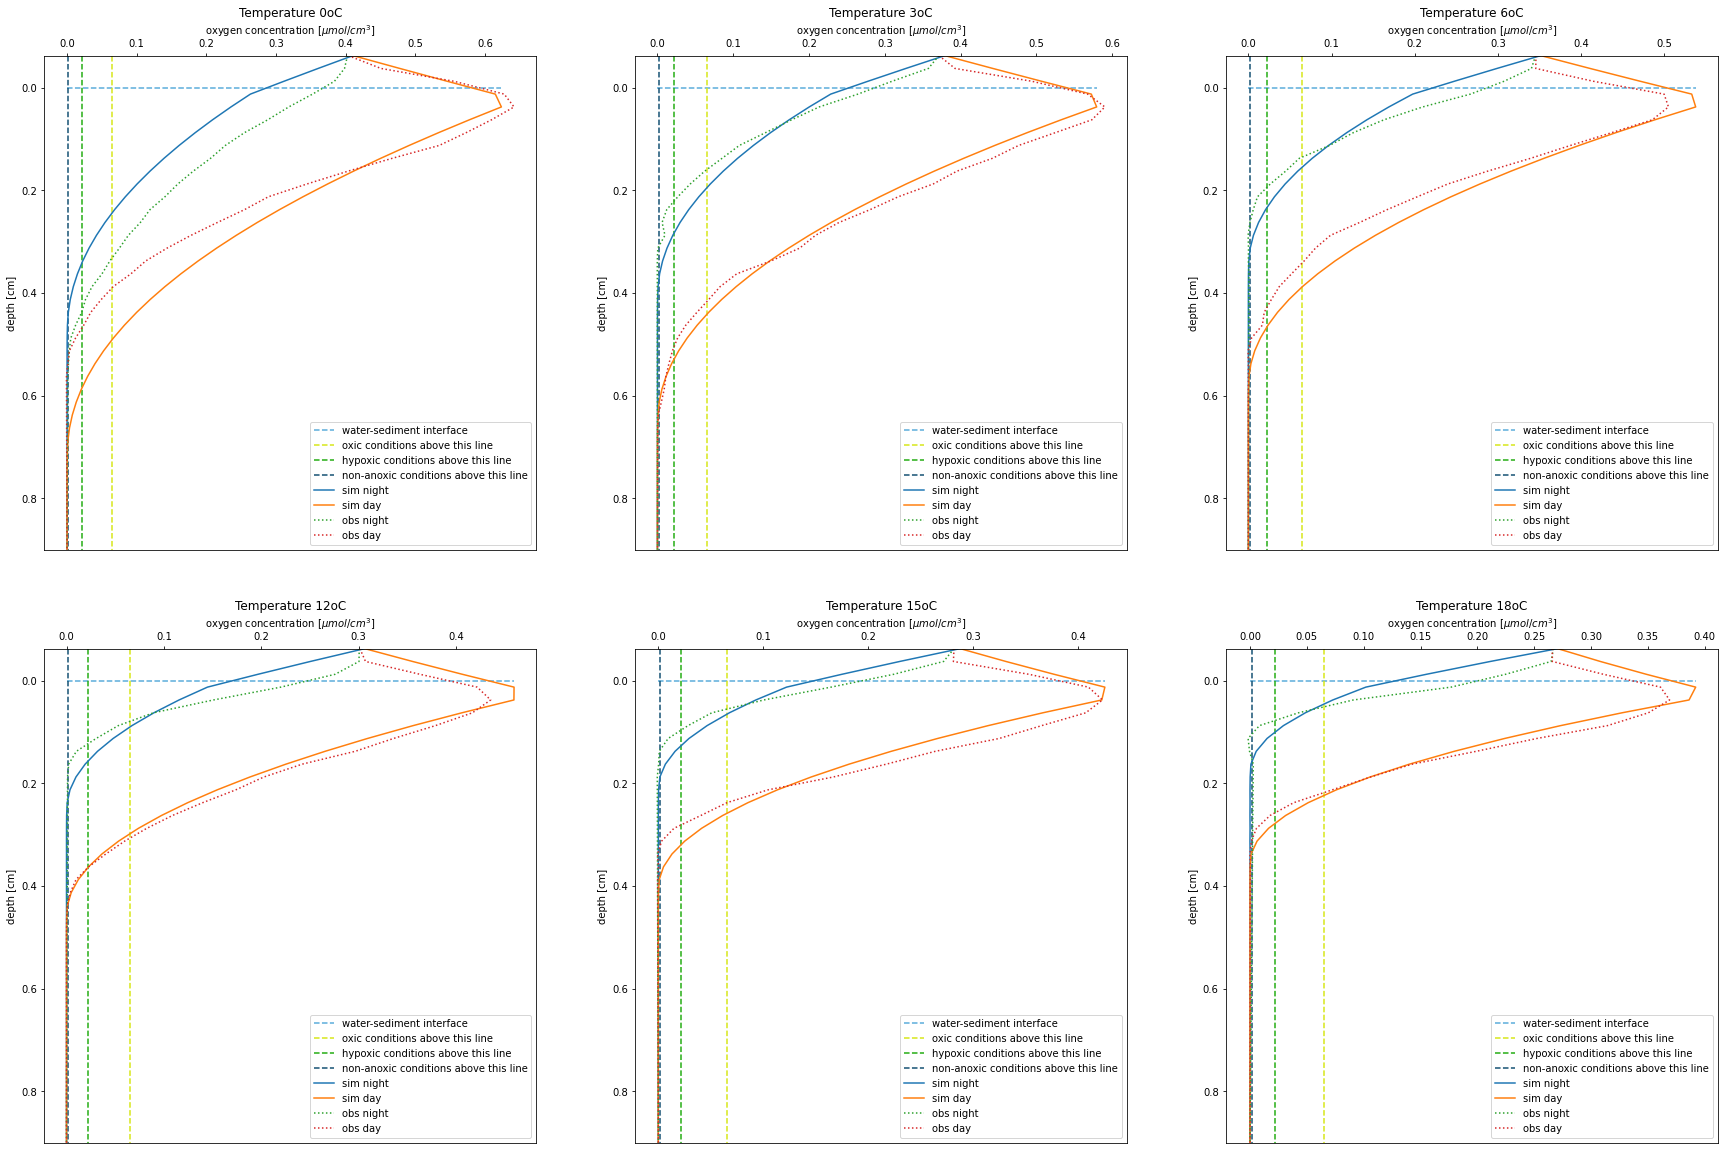

In [9]:
# For calibrating the "now" scenario

#NOTE: taken from autocalib above 
params = {
    'maxutil': 1e-9,
    'maxprod': 6e-05,   #umol/cm2/s
    'prodQ10': 1.4,
    'resp': 1.1e-4,     #umol/cm3/s
    'respQ10': 2.6,
    'ppO2': 21,         #%atm
    'salinity': 17
}


plot_calibs(df, params)

Run with two different porosities and plot the result

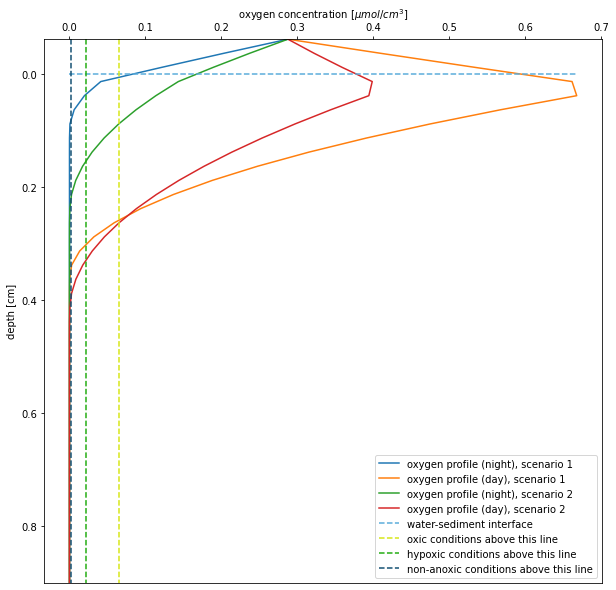

In [10]:
data_lo, minidx_lo, maxidx_lo = run_scenario(porosity=0.3, **params)
data_hi, minidx_hi, maxidx_hi = run_scenario(porosity=0.7, **params)

fig, ax = plt.subplots(1,1,sharex='all')
fig.set_size_inches(10.0, 10.0)

plot_profiles(ax, data_lo, minidx_lo, maxidx_lo, 1)
plot_profiles(ax, data_hi, minidx_hi, maxidx_hi, 2)
setup_profile_plot(ax, data_lo)

ax.legend()

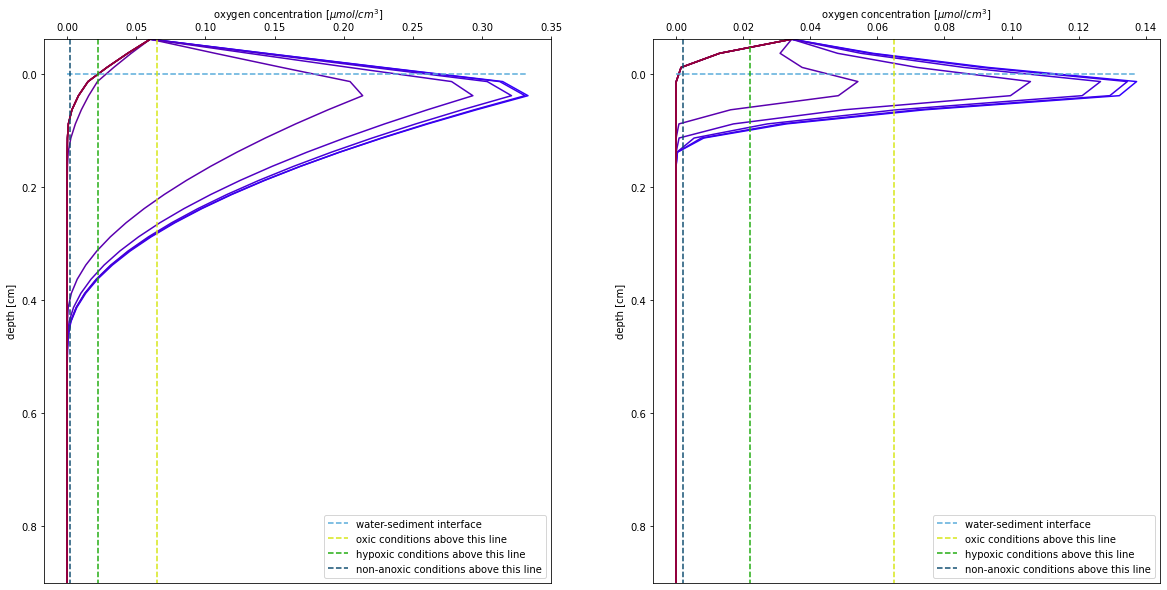

In [11]:
params_scenario = params.copy()
params_scenario['ppO2'] = 4
params_scenario['salinity'] = 35

day_length=21

fig, ax = plt.subplots(1,2)#,sharex='all')
fig.set_size_inches(20,10)

data1, minidx1, maxidx1 = run_scenario(temperature=5, day_length=day_length, **params_scenario)

for i, idx in enumerate(range(maxidx1-day_length, maxidx1-day_length+11, 1)):
    plot_profile(ax[0], data1, idx, color = '#%02x%02x%02x' % (50+10*i, 0, 255-20*i))

setup_profile_plot(ax[0], data1)
  

data2, minidx2, maxidx2 = run_scenario(temperature=35, day_length=day_length, **params_scenario)

for i, idx in enumerate(range(maxidx2-day_length, maxidx2-day_length+11, 1)):
    plot_profile(ax[1], data2, idx, color = '#%02x%02x%02x' % (50+10*i, 0, 255-20*i))
    
setup_profile_plot(ax[1], data2)
    
    

Make a function that computes the penetration depths in a data block at a given time index

In [12]:
def compute_penetration_depth(data, timeidx):
    
    def depth_of_index(index) :
        return (index - water_sed_idx + 0.5)*z_resolution
        
    def linear_intersection(x0, x1, C0, C1, C):
        xx = (C-C0)*(x1-x0)/(C1-C0) + x0
        if xx < x0 : xx=x0
        if xx > x1 : xx=x1
        return xx
    
    def depth_of_intersection(x0, x1, C0, C1, C):
        x = linear_intersection(x0, x1, C0, C1, C)
        return depth_of_index(x)
    
    oxicdepth = np.nan
    hypoxicdepth = np.nan
    zeroconcdepth = np.nan
    for x in range(water_sed_idx, nlevels) :
        
        x1 = x
        x0 = x-1
        C1 = data[timeidx, x1]
        C0 = C1
        if x > 0:
            C0 = data[timeidx,x0]
        
        if x == water_sed_idx :
            if C0 < oxic : oxicdepth = 0
            if C0 < hypoxic : hypoxicdepth = 0
            if C0 < zeroconc : zeroconcdepth = 0
        
        if (np.isnan(oxicdepth)) and C1 < oxic :
            oxicdepth = depth_of_intersection(x0, x1, C0, C1, oxic)
        if (np.isnan(hypoxicdepth))  and C1 < hypoxic :
            hypoxicdepth = depth_of_intersection(x0, x1, C0, C1, hypoxic)
        if (np.isnan(zeroconcdepth))  and C1 < zeroconc :
            zeroconcdepth = depth_of_intersection(x0, x1, C0, C1, zeroconc)
        
    if oxicdepth < 0 or np.isnan(oxicdepth) : oxicdepth=0
    if hypoxicdepth < 0 or np.isnan(hypoxicdepth) : hypoxicdepth=0
    if zeroconcdepth < 0 or np.isnan(zeroconcdepth) : zeroconcdepth=0
        
    return oxicdepth, hypoxicdepth, zeroconcdepth

def print_penetration_depth(data, timeidx):
    oxicdepth, hypoxicdepth, zeroconcdepth = compute_penetration_depth(data, timeidx)
    print("Penetration depths:")
    #print("(nan values signify that the depth happens below %g cm)" % (100.0-water_sed_idx)*z_resolution)
    #print("(negative values may signify that the condition does not occur at all)")
    print("Oxic conditions above %g cm" % oxicdepth)
    print("Hypoxic conditions above %g cm" % hypoxicdepth)
    print("Severely hypoxic conditions above %g cm" % zeroconcdepth)

Run with two different temperatures (also calibrating production rate)

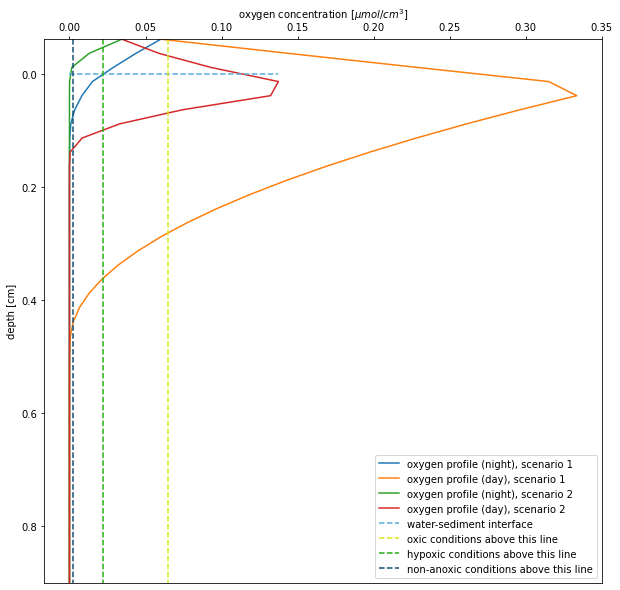

In [13]:

#note that we should probably have both lower production and respiration rates in the prehistoric conditions...
#.. so this could be tweaked some more

day_length = 21

#data1, minidx1, maxidx1 = run_scenario(temperature=4, ppO2=4, resp=1e-6, maxprod=0.8e-5, day_length=day_length)
#data2, minidx2, maxidx2 = run_scenario(temperature=35, ppO2=4, resp=1e-6, maxprod=1.7e-5, day_length=day_length)
#data1, minidx1, maxidx1 = run_scenario(temperature=4, ppO2=4, resp=9e-6, maxprod=1.7e-5, day_length=day_length)
#data2, minidx2, maxidx2 = run_scenario(temperature=35, ppO2=4, resp=9e-6, maxprod=1.7e-5, day_length=day_length)
#data1, minidx1, maxidx1 = run_scenario(temperature=4, **params_scenario, day_length=day_length)
#data2, minidx2, maxidx2 = run_scenario(temperature=35, **params_scenario, day_length=day_length)

fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 10)

plot_profiles(ax, data1, minidx1, maxidx1, 1)
plot_profiles(ax, data2, minidx2, maxidx2, 2)
setup_profile_plot(ax, data2)

In [14]:
#daytime penetration depths
print("daytime penetration depth, scenario1:")
print_penetration_depth(data1, maxidx1)
print("")
print("daytime penetration depth, scenario2:")
print_penetration_depth(data2, maxidx2)
print("")
#nighttime
print("nighttime penetration depth, scenario1:")
print_penetration_depth(data1, minidx1)
print("")
print("nighttime penetration depth, scenario2:")
print_penetration_depth(data2, minidx2)

daytime penetration depth, scenario1:
Penetration depths:
Oxic conditions above 0.280257 cm
Hypoxic conditions above 0.360933 cm
Severely hypoxic conditions above 0.444567 cm

daytime penetration depth, scenario2:
Penetration depths:
Oxic conditions above 0.0680733 cm
Hypoxic conditions above 0.0985812 cm
Severely hypoxic conditions above 0.132558 cm

nighttime penetration depth, scenario1:
Penetration depths:
Oxic conditions above 0 cm
Hypoxic conditions above 0 cm
Severely hypoxic conditions above 0.0765658 cm

nighttime penetration depth, scenario2:
Penetration depths:
Oxic conditions above 0 cm
Hypoxic conditions above 0 cm
Severely hypoxic conditions above 0 cm


In [15]:
relative_to_depth = max_display_depth

def compute_average_depth(data, initialidx) :
    totox  = 0.0
    tothyp = 0.0
    totsev = 0.0
    for idx in range(initialidx, initialidx+day_length):
        oxicdepth, hypoxicdepth, zeroconcdepth = compute_penetration_depth(data, idx)
        #print('ox:%f hyp:%f zer:%f' % (oxicdepth, hypoxicdepth, zeroconcdepth))
        totox+=oxicdepth
        tothyp+=hypoxicdepth-oxicdepth
        totsev+=zeroconcdepth-hypoxicdepth
    totox/=float(day_length)
    tothyp/=float(day_length)
    totsev/=float(day_length)
    
    return 100.0*(totox/relative_to_depth), 100.0*(tothyp/relative_to_depth), 100.0*(totsev/relative_to_depth)

def print_average_depth(data, initialidx):
    ox, hyp, sev = compute_average_depth(data, initialidx)
    print("average oxic: %f %%" % ox)
    print("average hypoxic: %f %%" % hyp)
    print("average severely hypoxic: %f %%" % sev)
    print("average anoxic: %f %%" % (100.0 - (sev+hyp+ox)) )
    print("")
#average penetration depths:

print("daily average intervals as %% of %gcm in scenario 1:" % relative_to_depth)
print_average_depth(data1, minidx1-day_length)

print("daily average intervals as %% of %gcm in scenario 2:" % relative_to_depth)
print_average_depth(data2, minidx2-day_length)

daily average intervals as % of 0.9cm in scenario 1:
average oxic: 15.989884 %
average hypoxic: 5.169967 %
average severely hypoxic: 9.040947 %
average anoxic: 69.799202 %

daily average intervals as % of 0.9cm in scenario 2:
average oxic: 2.674236 %
average hypoxic: 1.887041 %
average severely hypoxic: 1.682107 %
average anoxic: 93.756616 %



Make a function that 3d-plots a data block

In [16]:
def make_3d_plot(data) :
    
    maxidx = np.argmax(drange > max_display_depth)
    clipped_drange = drange[0:maxidx]
    clipped_data   = data[:,0:maxidx]
    
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')

    x = np.outer(np.ones(ntime), clipped_drange)
    y = np.outer(range(0,ntime), np.ones(len(clipped_drange)))

    cmap = 'cividis'
    offset = -2.7*np.max(data)
    
    ax.plot_surface(x, y, clipped_data, cmap=cmap, shade=True, alpha=0.9)#, edgecolor='black')
    ax.contour(x, y, clipped_data, levels=[zeroconc, hypoxic, oxic], colors='k', linestyles='solid', linewidths=3.0)
    ax.contour(x, y, clipped_data, levels=[zeroconc, hypoxic, oxic], colors=level_colors, linestyles='solid', linewidths=3.0, offset=offset)
    
    ax.plot([0, 0], [0, ntime], [offset, offset], '--', color=water_color, linewidth=3.0)
    
    #ax.set_title('Surface plot')
    ax.set_ylabel('time [h]')
    ax.set_xlabel('depth [cm]')
    ax.set_zlabel('oxygen conc [$umol/cm^3$]')
    
    
    l = tick.AutoLocator()
    l.create_dummy_axis()
    ticks = l.tick_values(0, np.max(data))
    ax.set_zticks(ticks)
    
    #print(type(ax.w_xaxis.pane))
    #ax.w_xaxis.pane.set_lw(10)
    
    #ax.set_xlim(drange[0], max_display_depth)
    ax.set_zlim(offset, np.max(data))

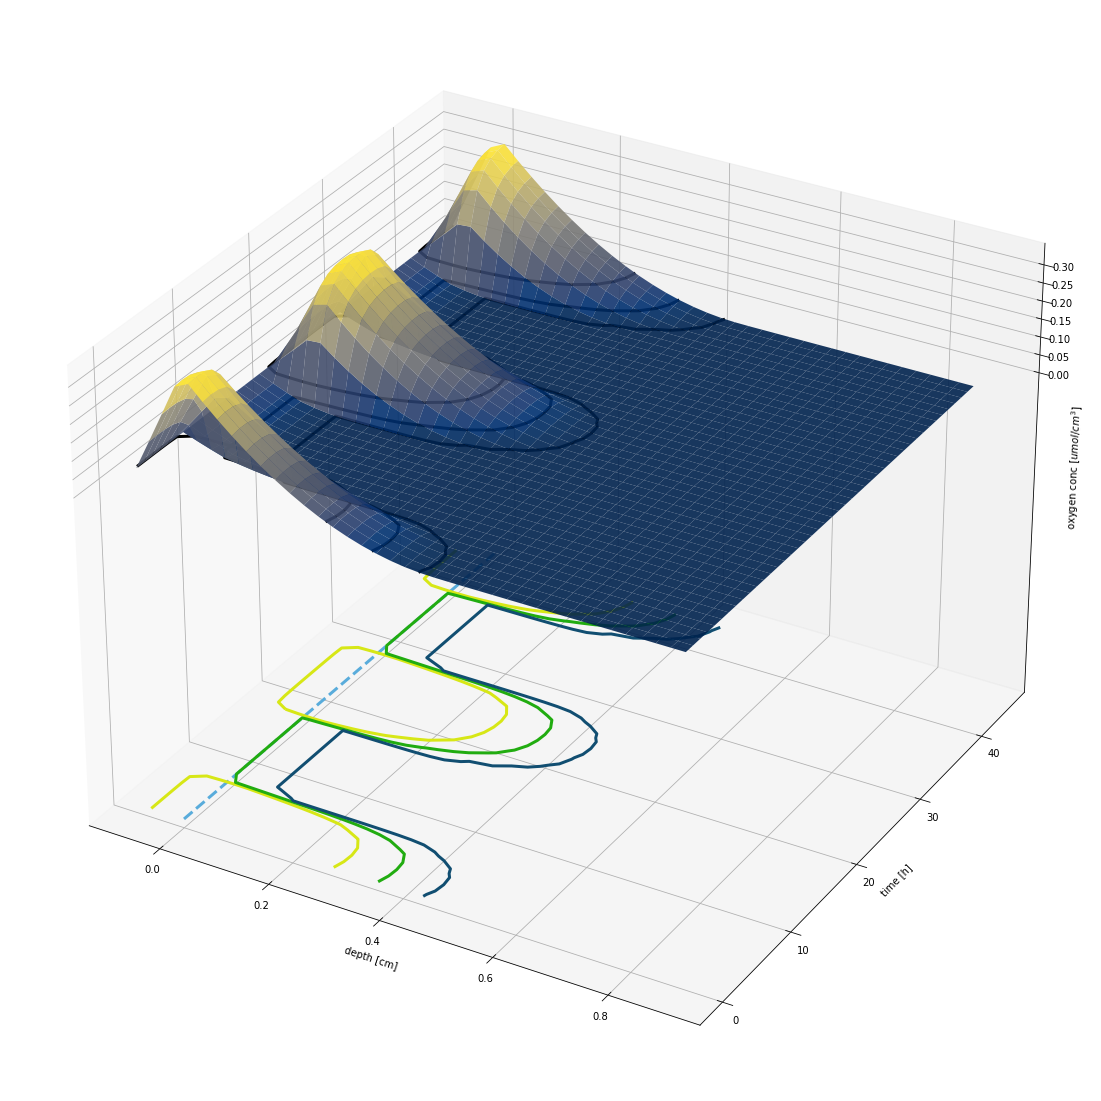

In [17]:
make_3d_plot(data1)
plt.savefig('plot1.png')

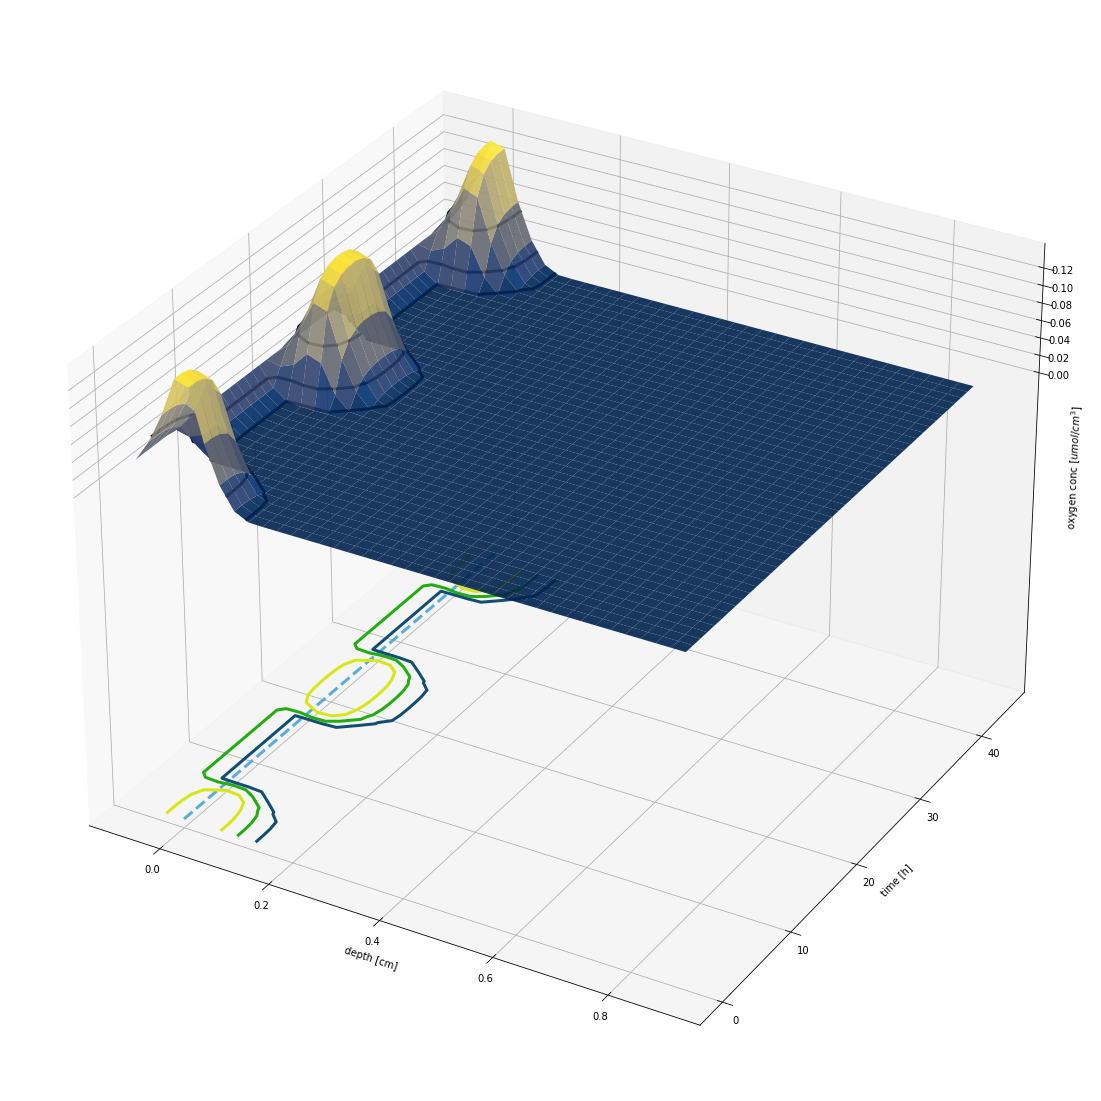

In [18]:
make_3d_plot(data2)
plt.savefig('plot2.png')